### Step 1: Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import *
import warnings
warnings.filterwarnings('ignore')

### Step 2: Define working directories

In [2]:
path_raw_data = 'C:/users/lbros/documents/mids/w207/final_project/raw_data/'
path_clean_data = 'C:/users/lbros/documents/mids/w207/final_project/clean_data/'

### Step 3: Load clean data

#### Split ratings

In [3]:
# load ratings dataframes
dev_train = pd.read_csv(path_clean_data + 'dev_train.csv')
dev_test = pd.read_csv(path_clean_data + 'dev_test.csv')
test_train = pd.read_csv(path_clean_data + 'test_train.csv')
test_test = pd.read_csv(path_clean_data + 'test_test.csv')

In [4]:
# drop 'Unnamed 0' column
dev_train.drop('Unnamed: 0', axis=1, inplace=True)
dev_test.drop('Unnamed: 0', axis=1, inplace=True)
test_train.drop('Unnamed: 0', axis=1, inplace=True)
test_test.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
# print dataframes shapes
print('Shapes')
print('dev_train:', dev_train.shape)
print('dev_test:', dev_test.shape)
print('test_train:', test_train.shape)
print('test_test:', test_test.shape)

Shapes
dev_train: (834600, 3)
dev_test: (5000, 3)
test_train: (17948251, 3)
test_test: (107150, 3)


In [6]:
# print dataframes columns
print(dev_train.columns)
print(dev_test.columns)
print(test_train.columns)
print(test_test.columns)

Index(['userId', 'imdb_id', 'rating'], dtype='object')
Index(['userId', 'imdb_id', 'rating'], dtype='object')
Index(['userId', 'imdb_id', 'rating'], dtype='object')
Index(['userId', 'imdb_id', 'rating'], dtype='object')


#### Movies

In [7]:
# load movies dataframe
movies_df = pd.read_csv(path_clean_data + 'movies_final.csv')

In [8]:
# print remaining imdb_id duplicates (if any)
print('Number of duplicated imdb_id: ', movies_df[movies_df['imdb_id'].duplicated()].shape[0])

Number of duplicated imdb_id:  546


In [9]:
# exclude remaining imdb_id duplicates
movies_df = movies_df[~movies_df['imdb_id'].duplicated(keep='last')]

In [10]:
# set imdb_id as index
movies_df.set_index('imdb_id', verify_integrity=True, inplace=True)

In [11]:
# remove fields unnamed: 0, id, tagline, description, production_countries, production_companies
movies_df = movies_df.drop(['Unnamed: 0', 'id', 'tagline', 'description', 'production_countries', 'production_companies'], axis=1)

In [12]:
# print dataframe shape
movies_df.shape

(29399, 173)

In [13]:
# print dataframe columns
movies_df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'originally_english',
       'overview', 'popularity', 'revenue', 'runtime', 'title', 'video',
       ...
       'zh', 'zu', 'canceled', 'in-production', 'planned', 'post-production',
       'released', 'rumored', 'cast_names', 'crew_names'],
      dtype='object', length=173)

### Step 4: Vectorize text fields

In [14]:
# create an instance of a TfidfVectorizer object for overview
# set it to keep the top 200 most significant words in the overview column
tfidf_overview = TfidfVectorizer(max_features=200)
t_overview = tfidf_overview.fit_transform(movies_df.overview)

# create a dataframe of the transformed top 200 overview features
overview = pd.DataFrame(t_overview.todense()).add_prefix('overview_')

# fill the NA values in the title column with unknown
movies_df.title.fillna('unknown', inplace=True)

# create an instance of a TfidfVectorizer object for title
# set it to keep the top 200 most significant words in the title column
tfidf_title = TfidfVectorizer(max_features=200)
t_title = tfidf_title.fit_transform(movies_df.title)

# create a dataframe of the transformed top 200 overview features
title = pd.DataFrame(t_title.todense()).add_prefix('title_')

# create an instance of a TfidfVectorizer object for cast names, keeping the 100 most significant cast names
tfidf_cast = TfidfVectorizer(max_features=100)
t_cast = tfidf_cast.fit_transform(movies_df.cast_names)

# create a dataframe of the transformed top 100 cast name features
cast = pd.DataFrame(t_cast.todense()).add_prefix('cast_')

# create an instance of a TfidfVectorizer for crew names, keeping the 100 most significant crew names
tfidf_crew = TfidfVectorizer(max_features=100)
t_crew = tfidf_crew.fit_transform(movies_df.crew_names)

# create a dataframe of the transformed top 100 crew name features
crew = pd.DataFrame(t_crew.todense()).add_prefix('crew_')

# concatenate these columns into a single dataframe
text = pd.concat([overview, title, cast, crew], axis=1)

# free-up memory deleting intermediate objects
del overview
del title
del cast
del crew

# drop the text columns that have been converted to numeric scores from movies_df
movies_df.drop(['overview', 'title', 'cast_names', 'crew_names'], axis=1, inplace=True)

# add back to the movies_df the numeric representations of the original text columns
movies_df = pd.concat([movies_df.reset_index(), text], axis=1).set_index('imdb_id')
print('movies_df shape: ', movies_df.shape)

# free-up memory deleting intermediate objects
del text

movies_df shape:  (29399, 769)


### Step 5: Normalize features (all between 0 and 1)

In [15]:
# transform movies_df in a numpy array
a = movies_df.iloc[:,0:].values

# create an instance of a MinMaxScaler and fit it to the numeric data
min_max_sc = MinMaxScaler()
num_rep = min_max_sc.fit_transform(a)
print('num_rep shape: ', num_rep.shape)

# free-up memory deleting intermediate objects
del a

num_rep shape:  (29399, 769)


### Step 6: Reduce dimensionality using PCA

### Step 7: Test and tune hyperparameters for different classifiers

#### Define auxiliary functions

In [16]:
def run_clf(user_id, clf, train_ratings_data=dev_train, test_ratings_data=dev_test, movies_data=movies_df, num_rep=num_rep):
    
    '''Run a classifier for a single user and return the score'''
    
    # get movies and ratings from user training data
    train_movies = train_ratings_data[train_ratings_data['userId']==user_id]['imdb_id']
    train_ratings = train_ratings_data[train_ratings_data['userId']==user_id]['rating']
    #print('User {} rated {} movies in training set.'.format(user_id, len(train_movies)))
    #print('User {} gave {} positive ratings and {} negative ratings.'.format(user_id, (train_ratings==1).sum(), (train_ratings==0).sum()), '\n')
    
    # get movie and rating for hold out user test data
    hold_out_movie = test_ratings_data[test_ratings_data['userId']==user_id]['imdb_id']
    hold_out_rating = test_ratings_data[test_ratings_data['userId']==user_id]['rating']
    #print('User {} rated {} movie in the hold-out set.'.format(user_id, len(hold_out_movie)))
    #print('User {} gave a {} rating for the hold-out movie.'.format(user_id, int(hold_out_rating)), '\n')
    
    # complement test data with other 99 randomly selected movies
    allowed_list = movies_data.loc[~movies_data.index.isin(train_movies.append(hold_out_movie))]
    rd_movies = allowed_list.sample(n=99, replace=False).index.to_series()
    test_movies = hold_out_movie.append(rd_movies)
    
    # extract X_train and X_test matrices
    X_train = num_rep[[movies_data.index.get_loc(x) for x in train_movies], :]
    #print('X_train shape:', X_train.shape)
    X_test = num_rep[[movies_data.index.get_loc(x) for x in test_movies], :]
    #print('X_test shape:', X_test.shape)
    
    # extrac y_train vector
    y_train = train_ratings.values
    #print('y_train shape:', y_train.shape, '\n')
    
    # fit training data
    clf.fit(X_train, y_train)
    # compute probabilities for each class
    proba = clf.predict_proba(X_test)
    # compute the ranking for class==test_ratings
    ranking = np.argsort(proba, axis=0)[:,clf.classes_[clf.classes_==int(hold_out_rating)]]
    # apply a positive hit if test example ranked on top-10 in descending order
    score = ranking[0] > 89
    
    return score

In [17]:
def get_hit_rate(user_list, clf, train_ratings_data=dev_train, test_ratings_data=dev_test, movies_data=movies_df, num_rep=num_rep):

    '''Compute hit rate across diferent users'''
    
    hit_list = []
    for user_id in user_list:
        score = run_clf(user_id, clf=clf, train_ratings_data=train_ratings_data, test_ratings_data=test_ratings_data, 
                            movies_data=movies_data, num_rep=num_rep)
        hit_list.append(bool(score))
    return sum(hit_list) / len(hit_list)

In [18]:
def get_hit_rate_by_rating(user_list, clf, train_ratings_data=dev_train, test_ratings_data=dev_test, movies_data=movies_df, num_rep=num_rep):
    
    '''Compute hit rate by user rating in the hold out movie'''
    
    # for different ratings in the hold out movie
    ratings = [0, 1]
    hit_rate_by_rating = []
    for r in ratings:
        # define the user_list as the subset of users who gave rate r in the hold out movie
        user_list = test_ratings_data[test_ratings_data['rating']==r]['userId']
        # compute the hit rate
        hit_rate = get_hit_rate(user_list=user_list, clf=clf, train_ratings_data=train_ratings_data, test_ratings_data=test_ratings_data, 
                                movies_data=movies_df, num_rep=num_rep)
        # append hit rate to the hit_rate_by_rating
        hit_rate_by_rating.append(hit_rate)
        # print results
        print('For rating=={} hit rate=={:.3f}'.format(r, hit_rate))
    
    return hit_rate_by_rating

In [19]:
def get_hit_rate_by_n_ratings(user_list, clf, train_ratings_data=dev_train, test_ratings_data=dev_test, movies_data=movies_df, num_rep=num_rep):
    
    '''Compute hit rate by number of ratings in the user training set'''
    
    # split users by number of ratings
    bins = [0, 50, 100, 150, 200, 20000]
    user_list_by_n_ratings = pd.cut(train_ratings_data.groupby('userId').count()['rating'], bins).reset_index('userId')
    intervals = user_list_by_n_ratings['rating'].unique()
    # for different intervals of number of ratings
    hit_rate_by_n_ratings = []
    for i in intervals:
        # define the user_list as the subset of users within the interval
        user_list = user_list_by_n_ratings[user_list_by_n_ratings['rating']==i]['userId']
        # compute the hit rate
        hit_rate = get_hit_rate(user_list=user_list, clf=clf, train_ratings_data=train_ratings_data, test_ratings_data=test_ratings_data, 
                                movies_data=movies_df, num_rep=num_rep)
        # append hit rate to the hit_rate_by_n_ratings
        hit_rate_by_n_ratings.append(hit_rate)
        # print results
        print('For interval=={} hit rate=={:.3f}'.format(i, hit_rate))
        
    return hit_rate_by_n_ratings

In [20]:
def run_gmm(user_id, n_components, train_ratings_data=dev_train, test_ratings_data=dev_test, movies_data=movies_df, num_rep=num_rep):
    
    '''Fit two GMMs, one for the positive and other for the negative examples, and use
    the weighted log probabilities to compute the ranking and return the score'''
    
    # get movies and ratings from user training data
    train_movies = train_ratings_data[train_ratings_data['userId']==user_id]['imdb_id']
    train_ratings = train_ratings_data[train_ratings_data['userId']==user_id]['rating']
    #print('User {} rated {} movies in training set.'.format(user_id, len(train_movies)))
    #print('User {} gave {} positive ratings and {} negative ratings.'.format(user_id, (train_ratings==1).sum(), (train_ratings==0).sum()), '\n')
    
    # get movie and rating for hold out user test data
    hold_out_movie = test_ratings_data[test_ratings_data['userId']==user_id]['imdb_id']
    hold_out_rating = test_ratings_data[test_ratings_data['userId']==user_id]['rating']
    #print('User {} rated {} movie in the hold-out set.'.format(user_id, len(hold_out_movie)))
    #print('User {} gave a {} rating for the hold-out movie.'.format(user_id, int(hold_out_rating)), '\n')
    
    # complement test data with other 99 randomly selected movies
    allowed_list = movies_data.loc[~movies_data.index.isin(train_movies.append(hold_out_movie))]
    rd_movies = allowed_list.sample(n=99, replace=False).index.to_series()
    test_movies = hold_out_movie.append(rd_movies)
    
    # extract X_train and X_test matrices
    X_train = num_rep[[movies_data.index.get_loc(x) for x in train_movies], :]
    #print('X_train shape:', X_train.shape)
    X_test = num_rep[[movies_data.index.get_loc(x) for x in test_movies], :]
    #print('X_test shape:', X_test.shape)
    
    # extrac y_train vector
    y_train = train_ratings.values
    #print('y_train shape:', y_train.shape, '\n')
    
    # fit two GMMs, one for the positive labels and one for the negative labels
    gmm_0 = GaussianMixture(n_components=n_components, covariance_type='full', random_state=100)
    gmm_0.fit(X_train[y_train==0])
    gmm_1 = GaussianMixture(n_components=n_components, covariance_type='full', random_state=100)
    gmm_1.fit(X_train[y_train==1])
    
    # compute the weighted log probabilities for each test example in both models
    log_prob_0 = gmm_0.score_samples(X_test)
    log_prob_1 = gmm_1.score_samples(X_test)
    proba = np.vstack((log_prob_0, log_prob_1)).T
    
    # compute the ranking for class==test_ratings
    ranking = np.argsort(proba, axis=0)[:,int(hold_out_rating)]
    # apply a positive hit if test example ranked on top-10 in descending order
    score = ranking[0] > 89
    
    return score

In [21]:
def get_hit_rate_gmm(user_list, n_components, train_ratings_data=dev_train, test_ratings_data=dev_test, movies_data=movies_df, num_rep=num_rep):

    '''Compute hit rate across diferent users for GMM'''
    
    hit_list = []
    for user_id in user_list:
        score = run_gmm(user_id, n_components=n_components, train_ratings_data=train_ratings_data, test_ratings_data=test_ratings_data, 
                            movies_data=movies_data, num_rep=num_rep)
        hit_list.append(bool(score))
    return sum(hit_list) / len(hit_list)

In [22]:
def run_cosim(user_id, train_ratings_data=dev_train, test_ratings_data=dev_test, movies_data=movies_df, num_rep=num_rep):
    
    '''Compute two cosine similarity distances for each example in the test set, one against the positive examples in the training
    set and other against the negative examples, and use the distances to compute the ranking and return the score'''
    
    # get movies and ratings from user training data
    train_movies = train_ratings_data[train_ratings_data['userId']==user_id]['imdb_id']
    train_ratings = train_ratings_data[train_ratings_data['userId']==user_id]['rating']
    #print('User {} rated {} movies in training set.'.format(user_id, len(train_movies)))
    #print('User {} gave {} positive ratings and {} negative ratings.'.format(user_id, (train_ratings==1).sum(), (train_ratings==0).sum()), '\n')
    
    # get movie and rating for hold out user test data
    hold_out_movie = test_ratings_data[test_ratings_data['userId']==user_id]['imdb_id']
    hold_out_rating = test_ratings_data[test_ratings_data['userId']==user_id]['rating']
    #print('User {} rated {} movie in the hold-out set.'.format(user_id, len(hold_out_movie)))
    #print('User {} gave a {} rating for the hold-out movie.'.format(user_id, int(hold_out_rating)), '\n')
    
    # complement test data with other 99 randomly selected movies
    allowed_list = movies_data.loc[~movies_data.index.isin(train_movies.append(hold_out_movie))]
    rd_movies = allowed_list.sample(n=99, replace=False).index.to_series()
    test_movies = hold_out_movie.append(rd_movies)
    
    # extract X_train and X_test matrices
    X_train = num_rep[[movies_data.index.get_loc(x) for x in train_movies], :]
    #print('X_train shape:', X_train.shape)
    X_test = num_rep[[movies_data.index.get_loc(x) for x in test_movies], :]
    #print('X_test shape:', X_test.shape)
    
    # extrac y_train vector
    y_train = train_ratings.values
    #print('y_train shape:', y_train.shape, '\n')
    
    # compute the cosine similarities, one for the positive labels and one for the negative labels
    cosim_0 = cosine_similarity(X_test, X_train[y_train==0]).sum(axis=1)
    cosim_1 = cosine_similarity(X_test, X_train[y_train==1]).sum(axis=1)
    distance = np.vstack((cosim_0, cosim_1)).T

    # compute the ranking for class==test_ratings
    ranking = np.argsort(distance, axis=0)[:,int(hold_out_rating)]
    # apply a positive hit if test example ranked on top-10 in ascending order
    score = ranking[0] < 10
    
    return score

In [23]:
def get_hit_rate_cosim(user_list, train_ratings_data=dev_train, test_ratings_data=dev_test, movies_data=movies_df, num_rep=num_rep):

    '''Compute hit rate across diferent users for cosine similarity'''
    
    hit_list = []
    for user_id in user_list:
        score = run_cosim(user_id, train_ratings_data=train_ratings_data, test_ratings_data=test_ratings_data, 
                          movies_data=movies_data, num_rep=num_rep)
        hit_list.append(bool(score))
    return sum(hit_list) / len(hit_list)

In [24]:
def run_baseline(user_id, train_ratings_data=dev_train, test_ratings_data=dev_test, movies_data=movies_df, num_rep=num_rep):
    
    '''Run a random classifier as a baseline'''
    
    # get movies and ratings from user training data
    train_movies = train_ratings_data[train_ratings_data['userId']==user_id]['imdb_id']
    train_ratings = train_ratings_data[train_ratings_data['userId']==user_id]['rating']
    #print('User {} rated {} movies in training set.'.format(user_id, len(train_movies)))
    #print('User {} gave {} positive ratings and {} negative ratings.'.format(user_id, (train_ratings==1).sum(), (train_ratings==0).sum()), '\n')
    
    # get movie and rating for hold out user test data
    hold_out_movie = test_ratings_data[test_ratings_data['userId']==user_id]['imdb_id']
    hold_out_rating = test_ratings_data[test_ratings_data['userId']==user_id]['rating']
    #print('User {} rated {} movie in the hold-out set.'.format(user_id, len(hold_out_movie)))
    #print('User {} gave a {} rating for the hold-out movie.'.format(user_id, int(hold_out_rating)), '\n')
    
    # complement test data with other 99 randomly selected movies
    allowed_list = movies_data.loc[~movies_data.index.isin(train_movies.append(hold_out_movie))]
    rd_movies = allowed_list.sample(n=99, replace=False).index.to_series()
    test_movies = hold_out_movie.append(rd_movies)
    
    # extract X_train and X_test matrices
    X_train = num_rep[[movies_data.index.get_loc(x) for x in train_movies], :]
    #print('X_train shape:', X_train.shape)
    X_test = num_rep[[movies_data.index.get_loc(x) for x in test_movies], :]
    #print('X_test shape:', X_test.shape)
    
    # extrac y_train vector
    y_train = train_ratings.values
    #print('y_train shape:', y_train.shape, '\n')
    
    # assign random probabilities for each class
    proba = np.random.uniform(low=0.0, high=1.0, size=100).reshape(100,1)
    # compute the ranking for class==test_ratings
    ranking = np.argsort(proba, axis=0)
    # apply a positive hit if test example ranked on top-10 in descending order
    score = ranking[0] > 89
    
    return score

In [25]:
def get_hit_rate_baseline(user_list, train_ratings_data=dev_train, test_ratings_data=dev_test, movies_data=movies_df, num_rep=num_rep):

    '''Compute hit rate across diferent users for random baseline'''
    
    hit_list = []
    for user_id in user_list:
        score = run_baseline(user_id, train_ratings_data=train_ratings_data, test_ratings_data=test_ratings_data, 
                             movies_data=movies_data, num_rep=num_rep)
        hit_list.append(bool(score))
    return sum(hit_list) / len(hit_list)

In [38]:
def run_ensemble(user_id, train_ratings_data=dev_train, test_ratings_data=dev_test, movies_data=movies_df, num_rep=num_rep):
    
    '''Run all classifiers for a single user and compute the average probability before returning the score'''
    
    # get movies and ratings from user training data
    train_movies = train_ratings_data[train_ratings_data['userId']==user_id]['imdb_id']
    train_ratings = train_ratings_data[train_ratings_data['userId']==user_id]['rating']
    #print('User {} rated {} movies in training set.'.format(user_id, len(train_movies)))
    #print('User {} gave {} positive ratings and {} negative ratings.'.format(user_id, (train_ratings==1).sum(), (train_ratings==0).sum()), '\n')
    
    # get movie and rating for hold out user test data
    hold_out_movie = test_ratings_data[test_ratings_data['userId']==user_id]['imdb_id']
    hold_out_rating = test_ratings_data[test_ratings_data['userId']==user_id]['rating']
    #print('User {} rated {} movie in the hold-out set.'.format(user_id, len(hold_out_movie)))
    #print('User {} gave a {} rating for the hold-out movie.'.format(user_id, int(hold_out_rating)), '\n')
    
    # complement test data with other 99 randomly selected movies
    allowed_list = movies_data.loc[~movies_data.index.isin(train_movies.append(hold_out_movie))]
    rd_movies = allowed_list.sample(n=99, replace=False).index.to_series()
    test_movies = hold_out_movie.append(rd_movies)
    
    # extract X_train and X_test matrices
    X_train = num_rep[[movies_data.index.get_loc(x) for x in train_movies], :]
    #print('X_train shape:', X_train.shape)
    X_test = num_rep[[movies_data.index.get_loc(x) for x in test_movies], :]
    #print('X_test shape:', X_test.shape)
    
    # extrac y_train vector
    y_train = train_ratings.values
    #print('y_train shape:', y_train.shape, '\n')
    
    # initialize the models
    bnb = BernoulliNB(alpha=0.001)
    rfc = RandomForestClassifier(n_estimators=2, criterion='entropy')
    svm = SVC(C=1.0, kernel='rbf', probability=True)
    knn = KNeighborsClassifier(n_neighbors=10)
    lr = LogisticRegression(C=0.0100)
    gmm_0 = GaussianMixture(n_components=3, covariance_type='full', random_state=100)
    gmm_1 = GaussianMixture(n_components=3, covariance_type='full', random_state=100)
    
    # fit training data
    bnb.fit(X_train, y_train)
    rfc.fit(X_train, y_train)
    svm.fit(X_train, y_train)
    knn.fit(X_train, y_train)
    lr.fit(X_train, y_train)
    gmm_0.fit(X_train[y_train==0])
    gmm_1.fit(X_train[y_train==1])
    
    # compute probabilities for each model for class==test_ratings
    bnb_proba = bnb.predict_proba(X_test)[:,int(hold_out_rating)].reshape(100,1)
    rfc_proba = rfc.predict_proba(X_test)[:,int(hold_out_rating)].reshape(100,1)
    svm_proba = svm.predict_proba(X_test)[:,int(hold_out_rating)].reshape(100,1)
    knn_proba = knn.predict_proba(X_test)[:,int(hold_out_rating)].reshape(100,1)
    lr_proba = lr.predict_proba(X_test)[:,int(hold_out_rating)].reshape(100,1)
    gmm_prob_0 = np.exp(gmm_0.score_samples(X_test))
    gmm_prob_1 = np.exp(gmm_1.score_samples(X_test))
    gmm_proba = np.vstack((gmm_prob_0, gmm_prob_1)).T[:,int(hold_out_rating)].reshape(100,1)
    
    # compute the average probabilities
    proba = np.hstack((bnb_proba, rfc_proba, svm_proba, knn_proba, lr_proba, gmm_proba)).mean(axis=1)
    
    # compute the ranking
    ranking = np.argsort(proba, axis=0)
    # apply a positive hit if test example ranked on top-10 in descending order
    score = ranking[0] > 89
    
    return score

In [39]:
def get_hit_rate_ensemble(user_list, train_ratings_data=dev_train, test_ratings_data=dev_test, movies_data=movies_df, num_rep=num_rep):

    '''Compute hit rate across diferent users for ensemble method'''
    
    hit_list = []
    for user_id in user_list:
        score = run_ensemble(user_id, train_ratings_data=train_ratings_data, test_ratings_data=test_ratings_data, 
                             movies_data=movies_data, num_rep=num_rep)
        hit_list.append(bool(score))
    return sum(hit_list) / len(hit_list)

#### Test different classifiers

In [28]:
sample_size = 200
clf_list = ['Base', 'Cosine Sim', 'BNB', 'RF', 'SVM', 'KNN', 'LR', 'GMM', 'Ensemble']
clf_scores = []

#### Baseline (random classifier)

In [29]:
# define user_list (random samples of 200 users from dev set)
user_list = np.random.choice(dev_train['userId'].unique(), size=sample_size, replace=False)
# compute the hit rate
hit_rate = get_hit_rate_baseline(user_list)
# print results
print('Baseline (random classifier)')
print('hit rate=={:.3f}'.format(hit_rate))
# append best_score to clf_scores
clf_scores.append(hit_rate)

Baseline (random classifier)
hit rate==0.090


#### Cosine similarity

In [30]:
# define user_list (random samples of 200 users from dev set)
user_list = np.random.choice(dev_train['userId'].unique(), size=sample_size, replace=False)
# compute the hit rate
hit_rate = get_hit_rate_cosim(user_list)
# print results
print('Cosine similarity')
print('hit rate=={:.3f}'.format(hit_rate))
# append best_score to clf_scores
clf_scores.append(hit_rate)

Cosine similarity
hit rate==0.105


#### BernoulliNB

In [31]:
# define range for alpha parameter
param_range = [0.0001, 0.001, 0.01, 0.1, 1, 2]
# for different values of parameter alpha
hit_rate_list = []
print('BernoulliNB')
for param in param_range:
    # define user_list (random samples of 200 users from dev set)
    user_list = np.random.choice(dev_train['userId'].unique(), size=sample_size, replace=False)
    # initialize classifier
    bnb = BernoulliNB(alpha=param)
    # compute the hit rate
    hit_rate = get_hit_rate(user_list, clf=bnb)
    # append hit rate to the hit_rate_list
    hit_rate_list.append(hit_rate)
    # print results
    print('For alpha=={:.4f} hit rate=={:.3f}'.format(param, hit_rate))
print('-'*50)
print('Best param: {:.4f}'.format(param_range[hit_rate_list.index(max(hit_rate_list))]))
print('Best hit rate: {:.3f}'.format(max(hit_rate_list)))
# append best_score to clf_scores
clf_scores.append(max(hit_rate_list))

BernoulliNB
For alpha==0.0001 hit rate==0.110
For alpha==0.0010 hit rate==0.140
For alpha==0.0100 hit rate==0.125
For alpha==0.1000 hit rate==0.105
For alpha==1.0000 hit rate==0.100
For alpha==2.0000 hit rate==0.065
--------------------------------------------------
Best param: 0.0010
Best hit rate: 0.140


#### Random Forest

In [32]:
# define range for n_estimators parameter
param_range = [1, 2, 5, 10, 50, 100]
# for different values of n_estimators parameter
hit_rate_list = []
print('Random Forest')
for param in param_range:
    # define user_list (random samples of 200 users from dev set)
    user_list = np.random.choice(dev_train['userId'].unique(), size=sample_size, replace=False)
    # initialize classifier
    rfc = RandomForestClassifier(n_estimators=param, criterion='entropy')
    # compute the hit rate
    hit_rate = get_hit_rate(user_list, clf=rfc)
    # append hit rate to the hit_rate_list
    hit_rate_list.append(hit_rate)
    # print results
    print('For n_estimators=={:3} hit rate=={:.3f}'.format(param, hit_rate))
print('-'*50)
print('Best param: {:3}'.format(param_range[hit_rate_list.index(max(hit_rate_list))]))
print('Best hit rate: {:.3f}'.format(max(hit_rate_list)))
# append best_score to clf_scores
clf_scores.append(max(hit_rate_list))

Random Forest
For n_estimators==  1 hit rate==0.090
For n_estimators==  2 hit rate==0.150
For n_estimators==  5 hit rate==0.120
For n_estimators== 10 hit rate==0.095
For n_estimators== 50 hit rate==0.115
For n_estimators==100 hit rate==0.135
--------------------------------------------------
Best param:   2
Best hit rate: 0.150


#### SVM

In [33]:
# define range for C parameter
param_range = [0.001, 0.01, 0.1, 1, 10]
# for different values of C parameter
hit_rate_list = []
print('SVM')
for param in param_range:
    # define user_list (random samples of 200 users from dev set)
    user_list = np.random.choice(dev_train['userId'].unique(), size=sample_size, replace=False)
    # initialize classifier
    svm = SVC(C=param, kernel='rbf', probability=True)
    # compute the hit rate
    hit_rate = get_hit_rate(user_list, clf=svm)
    # append hit rate to the hit_rate_list
    hit_rate_list.append(hit_rate)
    # print results
    print('For C=={:.3f} hit rate=={:.3f}'.format(param, hit_rate))
print('-'*50)
print('Best param: {:.3f}'.format(param_range[hit_rate_list.index(max(hit_rate_list))]))
print('Best hit rate: {:.3f}'.format(max(hit_rate_list)))
# append best_score to clf_scores
clf_scores.append(max(hit_rate_list))

SVM
For C==0.001 hit rate==0.100
For C==0.010 hit rate==0.090
For C==0.100 hit rate==0.120
For C==1.000 hit rate==0.145
For C==10.000 hit rate==0.115
--------------------------------------------------
Best param: 1.000
Best hit rate: 0.145


#### K-Nearest Neighbors

In [34]:
# define range for k (n_neighbors) parameter
param_range = [5, 10, 15, 20, 25]
# for different values of parameter k (n_beighbors)
hit_rate_list = []
print('K-Nearest Neighbors')
for param in param_range:
    # define user_list (random samples of 200 users from dev set)
    user_list = np.random.choice(dev_train['userId'].unique(), size=sample_size, replace=False)
    # initialize classifier
    knn = KNeighborsClassifier(n_neighbors=param)
    # compute the hit rate
    hit_rate = get_hit_rate(user_list, clf=knn)
    # append hit rate to the hit_rate_list
    hit_rate_list.append(hit_rate)
    # print results
    print('For k=={:2} hit rate=={:.3f}'.format(param, hit_rate))
print('-'*50)
print('Best param: {:2}'.format(param_range[hit_rate_list.index(max(hit_rate_list))]))
print('Best hit rate: {:.3f}'.format(max(hit_rate_list)))
# append best_score to clf_scores
clf_scores.append(max(hit_rate_list))

K-Nearest Neighbors
For k== 5 hit rate==0.090
For k==10 hit rate==0.125
For k==15 hit rate==0.095
For k==20 hit rate==0.105
For k==25 hit rate==0.100
--------------------------------------------------
Best param: 10
Best hit rate: 0.125


#### Logistic Regression

In [35]:
# define range for C parameter
param_range = [0.0001, 0.001, 0.01, 0.1, 1]
# for different values of C parameter
hit_rate_list = []
print('Logistic Regression')
for param in param_range:
    # define user_list (random samples of 200 users from dev set)
    user_list = np.random.choice(dev_train['userId'].unique(), size=sample_size, replace=False)
    # initialize classifier
    lr = LogisticRegression(C=param)
    # compute the hit rate
    hit_rate = get_hit_rate(user_list, clf=lr)
    # append hit rate to the hit_rate_list
    hit_rate_list.append(hit_rate)
    # print results
    print('For C=={:.4f} hit rate=={:.3f}'.format(param, hit_rate))
print('-'*50)
print('Best param: {:.4f}'.format(param_range[hit_rate_list.index(max(hit_rate_list))]))
print('Best hit rate: {:.3f}'.format(max(hit_rate_list)))
# append best_score to clf_scores
clf_scores.append(max(hit_rate_list))

Logistic Regression
For C==0.0001 hit rate==0.110
For C==0.0010 hit rate==0.070
For C==0.0100 hit rate==0.135
For C==0.1000 hit rate==0.060
For C==1.0000 hit rate==0.105
--------------------------------------------------
Best param: 0.0100
Best hit rate: 0.135


#### Gaussian Mixture Models

In [36]:
# define range for n_components parameter
param_range = [1, 2, 3, 4, 5]
# for different values of n_components parameter
hit_rate_list = []
print('GMM')
for param in param_range:
    # define user_list (random samples of 200 users from dev set)
    user_list = np.random.choice(dev_train['userId'].unique(), size=sample_size, replace=False)
    # compute the hit rate
    hit_rate = get_hit_rate_gmm(user_list, n_components=param)
    # append hit rate to the hit_rate_list
    hit_rate_list.append(hit_rate)
    # print results
    print('For n_components=={} hit rate=={:.3f}'.format(param, hit_rate))
print('-'*50)
print('Best param: {}'.format(param_range[hit_rate_list.index(max(hit_rate_list))]))
print('Best hit rate: {:.3f}'.format(max(hit_rate_list)))
# append best_score to clf_scores
clf_scores.append(max(hit_rate_list))

GMM
For n_components==1 hit rate==0.065
For n_components==2 hit rate==0.080
For n_components==3 hit rate==0.145
For n_components==4 hit rate==0.110
For n_components==5 hit rate==0.105
--------------------------------------------------
Best param: 3
Best hit rate: 0.145


#### Ensemble Learning

In [40]:
# define user_list (random samples of 200 users from dev set)
user_list = np.random.choice(dev_train['userId'].unique(), size=sample_size, replace=False)
# compute the hit rate
hit_rate = get_hit_rate_ensemble(user_list)
# print results
print('Ensemble Learning')
print('hit rate=={:.3f}'.format(hit_rate))
# append best_score to clf_scores
clf_scores.append(hit_rate)

Ensemble Learning
hit rate==0.085


#### Plot comparative results

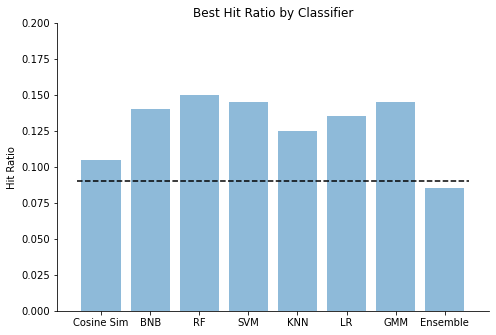

In [44]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar(clf_list[1:], clf_scores[1:], alpha=0.5)
ax.hlines(clf_scores[0], xmin=-0.5, xmax=7.5, color='black', linestyles='dashed', label='baseline')
ax.set_ylabel('Hit Ratio')
ax.set_ylim(0.0, 0.2)
ax.set_title('Best Hit Ratio by Classifier')
plt.show()